#Libraries to import

In [39]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#Preparing Dataset

In [40]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

#set aside Validation data from training data
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

#reshape the input images
for images, labels in train_loader:
    inputs = images.reshape(-1, 784)
    break



#Layers
Without Pytorch

In [41]:
input_size = inputs.shape[-1]
hidden_size = 32

layer1 = nn.Linear(input_size,hidden_size)
layer1_outputs = layer1(inputs)
relu_outputs = F.relu(layer1_outputs)

output_size = 10
layer2 = nn.Linear(hidden_size, output_size)
layer2_outputs = layer2(relu_outputs)

F.cross_entropy(layer2_outputs, labels)

tensor(2.3183, grad_fn=<NllLossBackward>)

#Model

In [46]:
class MnistModel(nn.Module):
  def __init__(self, input_size, hidden_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self,xb):
    xb = xb.view(xb.size(0),-1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def val_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss, 'val_acc': acc}

  def val_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


def accuracy(outputs,labels):
  _,predicts = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(predicts == labels).item()/len(predicts))

input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

    

#GPU

In [47]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else :
    return torch.device('cpu')

#Move data to GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device();

for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)        

torch.Size([128, 1, 28, 28])
cpu


#Training

In [51]:
def evaluate(model, val_loader):
  outputs = [model.val_step(batch) for batch in val_loader]
  return model.val_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
  return history


# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

#Evaluation

In [52]:
#Evaluation
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10107421875, 'val_loss': 2.3049862384796143}]

In [53]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2296, val_acc: 0.9324
Epoch [1], val_loss: 0.2061, val_acc: 0.9390
Epoch [2], val_loss: 0.1506, val_acc: 0.9546
Epoch [3], val_loss: 0.1513, val_acc: 0.9561
Epoch [4], val_loss: 0.1339, val_acc: 0.9602


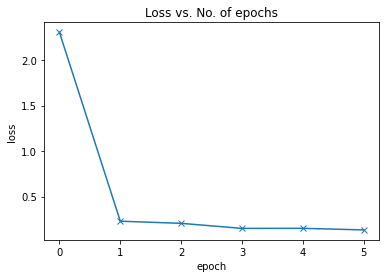

In [54]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

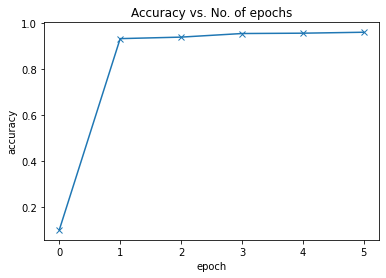

In [55]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

#Testing with individual images

In [56]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()
  

Label: 2 , Predicted: 2


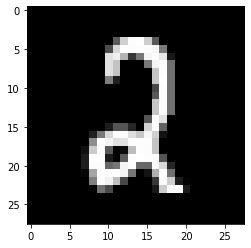

In [59]:
img, label = test_dataset[174]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))